In [1]:

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import cv2
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [2]:
path = untar_data(URLs.MNIST)

path.ls()

[PosixPath('/home/blue/.fastai/data/mnist_png/testing'),
 PosixPath('/home/blue/.fastai/data/mnist_png/training'),
 PosixPath('/home/blue/.fastai/data/mnist_png/models')]

In [3]:
il = ImageList.from_folder(path, convert_mode="L") # L is of pillow co
il.items[0] # item list thing that u to create a item

PosixPath('/home/blue/.fastai/data/mnist_png/testing/5/9114.png')

In [4]:
defaults.cmap="binary"
il

ImageList (70000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/blue/.fastai/data/mnist_png

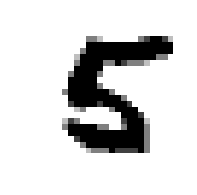

In [5]:
il[0].show()

In [6]:
sd = il.split_by_folder(train='training', valid='testing')
sd

ItemLists;

Train: ImageList (60000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/blue/.fastai/data/mnist_png;

Valid: ImageList (10000 items)
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
Path: /home/blue/.fastai/data/mnist_png;

Test: None

In [7]:
ls {path}

models/  testing/  training/


In [8]:
(path/'training').ls()

[PosixPath('/home/blue/.fastai/data/mnist_png/training/5'),
 PosixPath('/home/blue/.fastai/data/mnist_png/training/1'),
 PosixPath('/home/blue/.fastai/data/mnist_png/training/0'),
 PosixPath('/home/blue/.fastai/data/mnist_png/training/4'),
 PosixPath('/home/blue/.fastai/data/mnist_png/training/7'),
 PosixPath('/home/blue/.fastai/data/mnist_png/training/9'),
 PosixPath('/home/blue/.fastai/data/mnist_png/training/3'),
 PosixPath('/home/blue/.fastai/data/mnist_png/training/2'),
 PosixPath('/home/blue/.fastai/data/mnist_png/training/6'),
 PosixPath('/home/blue/.fastai/data/mnist_png/training/8')]

In [9]:
ll = sd.label_from_folder()
ll

LabelLists;

Train: LabelList (60000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
5,5,5,5,5
Path: /home/blue/.fastai/data/mnist_png;

Valid: LabelList (10000 items)
x: ImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
5,5,5,5,5
Path: /home/blue/.fastai/data/mnist_png;

Test: None

In [10]:
x,y = ll.train[0]

5 torch.Size([1, 28, 28])


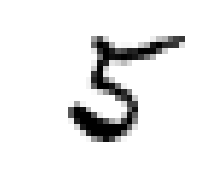

In [11]:
x.show()
print(y,x.shape)

In [12]:
tfms = ([*rand_pad(padding=3, size=28, mode="zeros")], [])

In [13]:
ll = ll.transform(tfms)

In [14]:
bs =128

In [15]:
data = ll.databunch(bs=bs).normalize()

In [16]:
x,y = data.train_ds[0]

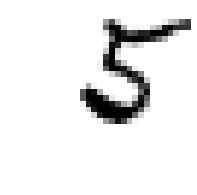

In [17]:
x.show()

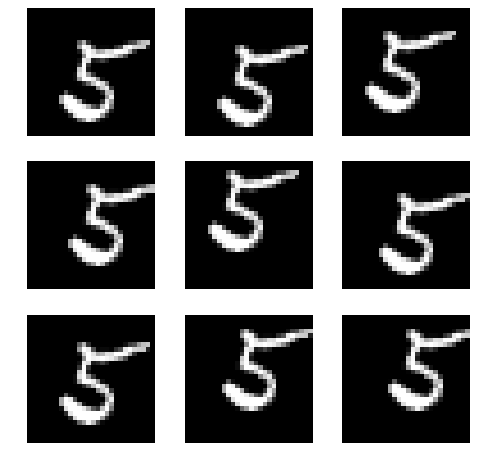

In [18]:
def _plot(i,j,ax):data.train_ds[0][0].show(ax, cmap="gray")
plot_multi(_plot, 3,3, figsize=(8,8))

In [19]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

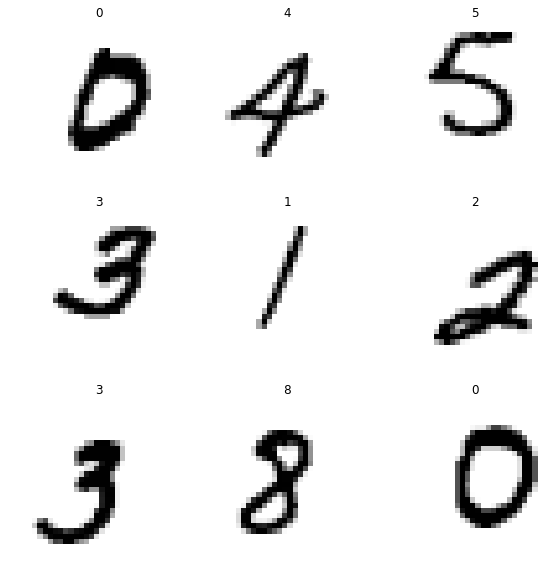

In [20]:
data.show_batch(rows=3, figsize=(8,8))

 ## Simple Cnn

In [21]:
def conv2(ni, nf):
    return conv_layer(ni,nf,stride=2)

In [22]:
model = nn.Sequential(
    
    conv2(1,8), # 14 
    conv2(8,16), #  7
    conv2(16,32), #  4
    conv2(32,16), #  2  
    conv2(16,10), #  1 
    
    Flatten() # remove (1,1), grid
)

In [23]:
learn = Learner(data, model, loss_func= nn.CrossEntropyLoss(), metrics= accuracy)

In [24]:
def selu(inplace:bool=False):
    """Return a selu activation, maybe `inplace`.
    https://arxiv.org/abs/1706.02515 
    """
    return nn.SELU(inplace=inplace) 




def conv_selu_layer(
        ni: int,
        nf: int,
        ks: int = 3,
        stride: int = 1,
        padding: int = None,
        bias: bool = None,
        is_1d: bool = False,
        use_activ: bool = True,
        transpose: bool = False,
        init: Callable = nn.init.kaiming_normal_,
        self_attention:bool=False
):
    "Create a sequence of convolutional (`ni` to `nf`), SELU (if `use_activ`) "
    if padding is None: padding = (ks-1)//2 if not transpose else 0
    conv_func = nn.ConvTranspose2d if transpose else nn.Conv1d if is_1d else nn.Conv2d
    conv = init_default(conv_func(ni, nf, kernel_size=ks, bias=bias, stride=stride, padding=padding), init)
    layers = [conv]
    if use_activ: layers.append(selu(True))
    if self_attention: layers.append(SelfAttention(nf))

    return nn.Sequential(*layers)


In [25]:
model = nn.Sequential(
    conv_selu_layer(1, 8 , stride=2),   # 14
    conv_selu_layer(8, 16, stride=2),  # 7
    conv_selu_layer(16, 32, stride=2), # 4
    conv_selu_layer(32, 16, stride=2), # 2
    conv_selu_layer(16, 10, stride=2), # 1
    Flatten()      # remove (1,1) grid
)

In [26]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [27]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 14, 14]          72         True      
______________________________________________________________________
SELU                 [8, 14, 14]          0          False     
______________________________________________________________________
Conv2d               [16, 7, 7]           1,152      True      
______________________________________________________________________
SELU                 [16, 7, 7]           0          False     
______________________________________________________________________
Conv2d               [32, 4, 4]           4,608      True      
______________________________________________________________________
SELU                 [32, 4, 4]           0          False     
______________________________________________________________________
Conv2d               [16, 2, 2]           4,608      True      
______________________________________________________________

In [28]:
xb = xb.cuda()
model(xb).shape

torch.Size([128, 10])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


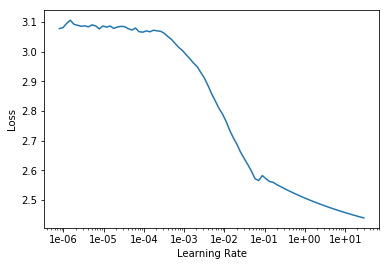

In [29]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

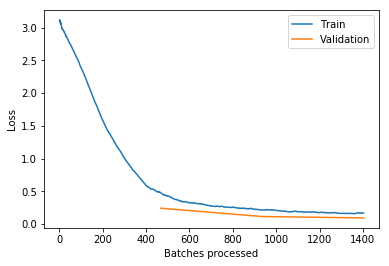

In [32]:
learn.fit_one_cycle(3, max_lr=.002)
learn.recorder.plot_losses()

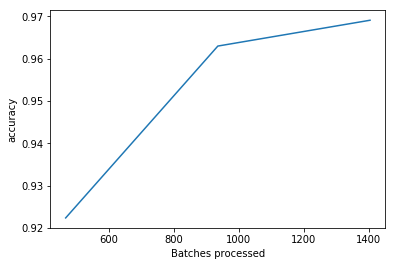

In [33]:
learn.recorder.plot_metrics()

In [35]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.167609,0.092732,0.970500,00:05
1,0.156267,0.091459,0.971600,00:05
2,0.147962,0.089398,0.972100,00:06


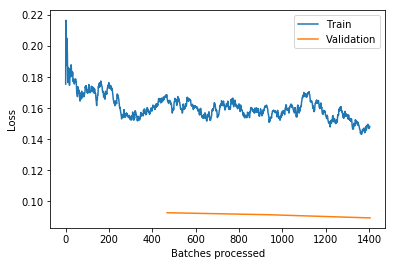

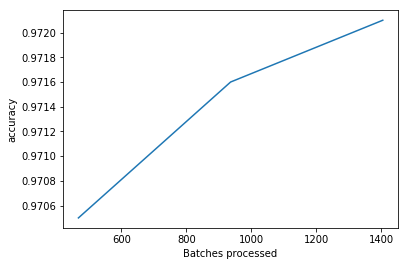

In [36]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()


In [42]:

learn.fit_one_cycle(2, max_lr=slice(1e-6))

epoch,train_loss,valid_loss,accuracy,time
0,0.153902,0.089328,0.972200,00:05
1,0.158348,0.089313,0.971900,00:06


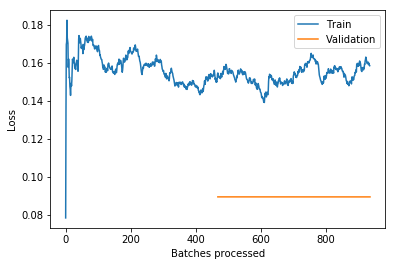

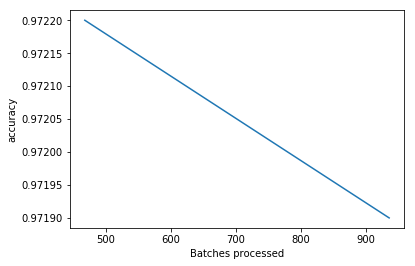

In [43]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,accuracy,time
0,0.157389,0.089156,0.972300,00:05
1,0.150238,0.087762,0.971800,00:08


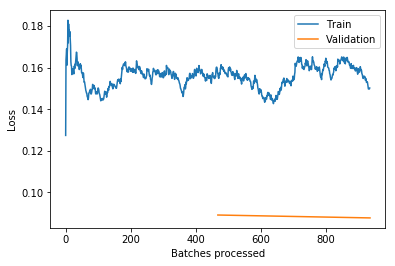

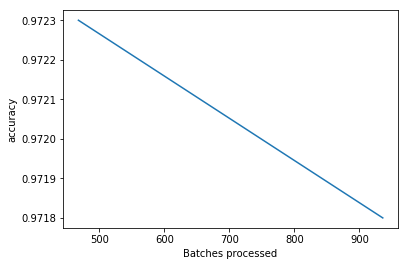

In [44]:

learn.fit_one_cycle(2, max_lr=slice(1e-4))
learn.recorder.plot_losses()
learn.recorder.plot_metrics()